#Installing and Importing Libraries

In [1]:
!pip install PyPDF2 sentence_transformers groq requests scikit-learn fuzzywuzzy -q
!python -m spacy download en_core_web_sm -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 51.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
import os
import json
import PyPDF2
import spacy
import random
import matplotlib.pyplot as plt
import re
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from tqdm import tqdm
from sentence_transformers import SentenceTransformer, util
from groq import Groq
from google.colab import drive
import nltk
from typing import List, Dict, Optional
from collections import deque
from PyPDF2 import PdfReader
from nltk.tokenize import sent_tokenize
nltk.download('punkt', quiet=True)

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


True

# Mounting the Drive

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Groq API Key

In [4]:
GROQ_API_KEY = "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"

# JD and Resume PDFs -> JSON Files

In [5]:
JOB_ROLES = [
    "Actuarial Analyst",
    "Computer Vision Engineer",
    "Data Analyst",
    "Data Engineer",
    "Data Scientist",
    "Financial Market Analyst",
    "Junior Analyst Developer",
    "MERN Developer",
    "Product Associate",
    "SDE_ SWE_ Software Development Engineer_ Software Engineer"
]

In [6]:
def extract_text_from_pdf(pdf_path):
    job_description = ""
    with open(pdf_path, 'rb') as pdf_file:
        pdf_reader = PyPDF2.PdfReader(pdf_file)
        for page in pdf_reader.pages:
            job_description += page.extract_text()
    return job_description

def find_best_matching_role(sentence_model, job_description):
    job_description_embedding = sentence_model.encode(job_description, convert_to_tensor=True)
    job_roles_embeddings = sentence_model.encode(JOB_ROLES, convert_to_tensor=True)
    cosine_similarities = util.pytorch_cos_sim(job_description_embedding, job_roles_embeddings)
    best_match_index = cosine_similarities.argmax().item()
    return JOB_ROLES[best_match_index], cosine_similarities[0][best_match_index].item()

def ask_question(question, modelname):
    client = Groq(api_key=GROQ_API_KEY)
    completion = client.chat.completions.create(
        model=modelname,
        messages=[
            {"role": "system", "content": "You are an expert in understanding and generating Job Descriptions and Resumes in CSE field."},
            {"role": "user", "content": question}
        ],
        temperature=0.5,
        max_tokens=1024,
        top_p=1,
        stream=True,
        stop=None,
    )
    response = ""
    for chunk in completion:
        response += chunk.choices[0].delta.content or ""
    return response

def analyze_job_description(pdf_path, output_path, modelname):
    try:
        sentence_model = SentenceTransformer('all-MiniLM-L6-v2')
        nlp = spacy.load("en_core_web_sm")
        job_description = extract_text_from_pdf(pdf_path)
        best_role, _ = find_best_matching_role(sentence_model, job_description)
        get_skills_prompt = f"Here is a job description: {job_description}.\n\nUnderstand it and list all the required skills in a Python list format. Respond only with a Python list of skill names, and avoid any extra text or new lines."
        get_eligibility_prompt = f"Here is a job description: {job_description}.\n\nUnderstand it and list all the required eligibility criteria in a Python list format. Respond only with a Python list of eligibility items, and avoid any extra text or new lines."
        skills = ask_question(get_skills_prompt, modelname)
        eligibility = ask_question(get_eligibility_prompt, modelname)
        result = {
            "role": best_role,
            "skills": skills,
            "eligibility": eligibility
        }
        with open(output_path, 'w') as json_file:
            json.dump(result, json_file, indent=4)
        return result
    except Exception as e:
        import traceback
        traceback.print_exc()
        return None

def analyze_resume(pdf_path, output_path, modelname):
    try:
        resume_text = extract_text_from_pdf(pdf_path)
        person_details_prompt = (
            f"Extract the person's details (name, phone, email, location) from this resume text: {resume_text}. "
            "Return the details strictly as a Python dictionary with keys 'name', 'phone', 'email', and 'location', and provide no extra text."
        )
        education_prompt = (
            f"Extract the education details (degree, university, dates) from this resume text: {resume_text}. "
            "Return the information strictly as a list of dictionaries, where each dictionary contains 'degree', 'university', and 'dates'. Provide no extra text."
        )
        skills_prompt = (
            f"Extract the skills from this resume text: {resume_text}. "
            "Return the skills strictly as a Python list of skill names, and provide no extra text."
        )
        work_ex_prompt = (
            f"Extract the work experience (company, role, dates, responsibilities) from this resume text: {resume_text}. "
            "Return the information strictly as a list of dictionaries, with each dictionary containing 'company', 'role', 'dates', and 'responsibilities'. Provide no extra text."
        )
        projects_prompt = (
            f"Extract the projects (name, description, technologies used) from this resume text: {resume_text}. "
            "Return each project strictly as a dictionary with 'name', 'description', and 'technologies_used' keys, and return all projects in a list format. Provide no extra text."
        )
        extras_prompt = (
            f"Extract any additional information (awards, certifications, volunteer experience) from this resume text: {resume_text}. "
            "Return the information strictly as a list of dictionaries with each dictionary containing 'type' and 'details' for each extra item. Provide no extra text."
        )
        person_details = ask_question(person_details_prompt, modelname)
        education = ask_question(education_prompt, modelname)
        skills = ask_question(skills_prompt, modelname)
        work_ex = ask_question(work_ex_prompt, modelname)
        projects = ask_question(projects_prompt, modelname)
        extras = ask_question(extras_prompt, modelname)
        result = {
            "person_details": person_details,
            "education": education,
            "skills": skills,
            "work_ex": work_ex,
            "projects": projects,
            "extras": extras
        }
        with open(output_path, 'w') as json_file:
            json.dump(result, json_file, indent=4)
        return result
    except Exception as e:
        print(f"Error processing file: {str(e)}")
        return None

In [7]:
# Testing

# Resume_pdf_path = "/content/drive/My Drive/LLM_RESUME_DATA/LLM Project Final/Resumes PDFs/2024-02-17_17-25-53_0.pdf"
# Resume_output_json_path = "/content/drive/My Drive/LLM_RESUME_DATA/LLM Project Final/Mid Review 2/extraded_resume.json"
# Jd_pdf_path = "/content/drive/My Drive/LLM_RESUME_DATA/LLM Project Final/Job Descriptions PDFs/Copy of Software Engineer (4).pdf"
# Jd_output_json_path = "/content/drive/My Drive/LLM_RESUME_DATA/LLM Project Final/Mid Review 2/extracted_jd.json"
# extracted_resume_data = analyze_resume(Resume_pdf_path, Resume_output_json_path)
# extracted_JD = analyze_job_description(Jd_pdf_path, Jd_output_json_path)
# for key, value in extracted_resume_data.items():
#     print(f"{key}: {value}")
# for key, value in extracted_JD.items():
#     print(f"{key}: {value}")

 # R1: Prompt + Resume + JD -> Base LLM -> Enhanced Resume

In [8]:
def enhance_resume(jd_json_path, resume_json_path, output_path, modelname):
    try:
        with open(jd_json_path, 'r') as f:
            jd_data = json.load(f)
        with open(resume_json_path, 'r') as f:
            resume_data = json.load(f)

        skills = resume_data.get('skills', {})
        work_ex = resume_data.get('work_ex', {})
        projects = resume_data.get('projects', {})
        extras = resume_data.get('extras', {})

        skills_prompt = f"""
        Original skills section: {skills}
        Job description: {jd_data}

        Please enhance the skills section by:
        1. Aligning it with the job description
        2. Using industry-standard terminology and formatting
        3. Prioritizing the most relevant skills first

        Enhanced skills section (maintain the original format):
        """

        work_ex_prompt = f"""
        Original work experience: {work_ex}
        Job description requirements: {jd_data}

        Please enhance the work experience section by:
        1. Highlighting experiences that match the job requirements
        2. Using industry-standard terminology
        3. Quantifying achievements where possible
        4. Focusing on relevant responsibilities

        Enhanced work experience section (maintain the original format):
        """

        projects_prompt = f"""
        Original projects section: {projects}
        Job description requirements: {jd_data}

        Please enhance the projects section by:
        1. Highlighting projects that demonstrate required skills
        2. Using industry-standard technical terminology
        3. Emphasizing problem-solving and results
        4. Including relevant technical details

        Enhanced projects section (maintain the original format):
        """

        extras_prompt = f"""
        Original extras section: {extras}
        Job requirements: {jd_data}

        Please enhance the extras section by:
        1. Highlighting relevant certifications and achievements
        2. Including industry-specific accomplishments
        3. Adding relevant professional memberships or activities
        4. Removing less relevant information

        Enhanced extras section (maintain the original format):
        """

        enhanced_skills = ask_question(skills_prompt, modelname)
        enhanced_work_ex = ask_question(work_ex_prompt, modelname)
        enhanced_projects = ask_question(projects_prompt, modelname)
        enhanced_extras = ask_question(extras_prompt, modelname)

        enhanced_resume = {
            "person_details": resume_data.get('person_details', {}),
            "education": resume_data.get('education', {}),
            "skills": enhanced_skills,
            "work_ex": enhanced_work_ex,
            "projects": enhanced_projects,
            "extras": enhanced_extras
        }

        with open(output_path, 'w') as f:
            json.dump(enhanced_resume, f, indent=4)

        return enhanced_resume

    except FileNotFoundError as e:
        print(f"Error: Could not find input file - {str(e)}")
        return None
    except json.JSONDecodeError as e:
        print(f"Error: Invalid JSON format - {str(e)}")
        return None
    except Exception as e:
        print(f"Error enhancing resume: {str(e)}")
        return None

In [9]:
# Testing

# enhanced_resume_output_path = "/content/drive/My Drive/LLM_RESUME_DATA/LLM Project Final/Mid Review 2/enhanced_resume_R1.json"
# R1 = enhance_resume(Jd_output_json_path, Resume_output_json_path, enhanced_resume_output_path)
# for key, value in R1.items():
#     print(f"{key}: {value}")

# Setting Up RAG

In [10]:
class RAGSystem:
    def __init__(self, api_key: str):
        self.api_key = api_key
        self.client = Groq(api_key=api_key)
        self.embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
        self.conversation_history = deque(maxlen=5)

    def extract_text_from_pdf(self, pdf_path: str) -> str:
        try:
            with open(pdf_path, 'rb') as file:
                reader = PdfReader(file)
                text = ""
                for page in reader.pages:
                    text += page.extract_text() + " "
            return text.strip()
        except Exception as e:
            print(f"Error reading PDF {pdf_path}: {e}")
            return ""

    def create_chunks(self, text: str, chunk_size: int = 500) -> List[str]:
        sentences = sent_tokenize(text)
        chunks = []
        current_chunk = ""

        for sentence in sentences:
            if len(current_chunk) + len(sentence) < chunk_size:
                current_chunk += " " + sentence
            else:
                if current_chunk:
                    chunks.append(current_chunk.strip())
                current_chunk = sentence

        if current_chunk:
            chunks.append(current_chunk.strip())

        return chunks

    def get_embeddings(self, texts: List[str]):
        return self.embedding_model.encode(texts)

    def find_relevant_chunks(self, query: str, chunks: List[str], top_k: int = 3) -> List[str]:
        query_embedding = self.embedding_model.encode([query])
        chunk_embeddings = self.embedding_model.encode(chunks)
        similarities = chunk_embeddings @ query_embedding.T
        top_indices = similarities.argsort(axis=0)[-top_k:][::-1]
        return [chunks[idx[0]] for idx in top_indices]

    def get_llm_response(self, query: str, context: str) -> str:
        history_context = "\n".join([f"Q: {q}\nA: {a}" for q, a in self.conversation_history])

        prompt = f"""Based on the following context and conversation history, please answer the question.
        If the answer cannot be found in the context, say so clearly.

        Context: {context}

        Previous Conversation:
        {history_context}

        Question: {query}

        Answer:"""

        try:
            completion = self.client.chat.completions.create(
                model="llama-3.1-70b-versatile",
                messages=[
                    {"role": "system", "content": "You are an expert in analyzing job descriptions and career-related documents."},
                    {"role": "user", "content": prompt}
                ],
                temperature=0.5,
                max_tokens=1024,
                stream=True
            )

            response = ""
            for chunk in completion:
                if chunk.choices[0].delta.content:
                    response += chunk.choices[0].delta.content

            return response.strip()

        except Exception as e:
            print(f"Error getting LLM response: {e}")
            return "I encountered an error while generating the response."

    def update_conversation_history(self, query: str, answer: str):
        self.conversation_history.append((query, answer))

    def process_query(self, folder_path: str, query: str) -> Dict[str, any]:
        try:
            pdf_files = [f for f in os.listdir(folder_path) if f.endswith('.pdf')]
            if not pdf_files:
                return {"answer": "No PDF files found in the specified folder.", "sources": []}
            all_chunks = []
            sources_map = {}

            for pdf_file in pdf_files:
                file_path = os.path.join(folder_path, pdf_file)
                text = self.extract_text_from_pdf(file_path)
                if text:
                    chunks = self.create_chunks(text)
                    all_chunks.extend(chunks)
                    for chunk in chunks:
                        sources_map[chunk] = pdf_file

            if not all_chunks:
                return {"answer": "No content could be extracted from the PDFs.", "sources": []}

            relevant_chunks = self.find_relevant_chunks(query, all_chunks)
            sources = [sources_map[chunk] for chunk in relevant_chunks]
            context = "\n".join(relevant_chunks)
            answer = self.get_llm_response(query, context)
            self.update_conversation_history(query, answer)

            return {
                "answer": answer,
                "sources": list(set(sources))
            }

        except Exception as e:
            print(f"Error in RAG pipeline: {e}")
            return {
                "answer": "An error occurred while processing your query.",
                "sources": []
            }

#R2: Prompt + Resume + JD + RAG -> Base LLM -> Enhanced Resume

In [11]:
def enhance_resume_with_rag(jd_json_path: str, resume_json_path: str, output_path: str, rag_folder_path: str, modelname: str) -> Dict:
    try:
        rag_system = RAGSystem(api_key=GROQ_API_KEY)

        with open(jd_json_path, 'r') as f:
            jd_data = json.load(f)
        with open(resume_json_path, 'r') as f:
            resume_data = json.load(f)

        role_query = f"What are the key skills, responsibilities, and best practices for a {jd_data.get('role', '')} role?"
        rag_knowledge = rag_system.process_query(rag_folder_path, role_query)

        skills = resume_data.get('skills', {})
        work_ex = resume_data.get('work_ex', {})
        projects = resume_data.get('projects', {})
        extras = resume_data.get('extras', {})

        skills_prompt = f"""
        Original skills section: {skills}
        Job description requirements: {jd_data}
        Industry knowledge from our database: {rag_knowledge['answer']}

        Please enhance the skills section by:
        1. Aligning it with the job description
        2. Incorporating relevant industry-standard skills from our knowledge base
        3. Using proper terminology and formatting
        4. Prioritizing the most relevant skills first

        Enhanced skills section (maintain the original format):
        """

        work_ex_prompt = f"""
        Original work experience: {work_ex}
        Job description requirements: {jd_data}
        Industry knowledge: {rag_knowledge['answer']}

        Please enhance the work experience section by:
        1. Highlighting experiences that match the job requirements
        2. Using industry-standard terminology
        3. Quantifying achievements where possible
        4. Focusing on relevant responsibilities

        Enhanced work experience section (maintain the original format):
        """

        projects_prompt = f"""
        Original projects section: {projects}
        Job description requirements: {jd_data}
        Industry knowledge: {rag_knowledge['answer']}

        Please enhance the projects section by:
        1. Highlighting projects that demonstrate required skills
        2. Using industry-standard technical terminology
        3. Emphasizing problem-solving and results
        4. Including relevant technical details

        Enhanced projects section (maintain the original format):
        """

        extras_prompt = f"""
        Original extras section: {extras}
        Job requirements: {jd_data}
        Industry knowledge: {rag_knowledge['answer']}

        Please enhance the extras section by:
        1. Highlighting relevant certifications and achievements
        2. Including industry-specific accomplishments
        3. Adding relevant professional memberships or activities
        4. Removing less relevant information

        Enhanced extras section (maintain the original format):
        """

        enhanced_skills = ask_question(skills_prompt, modelname)
        enhanced_work_ex = ask_question(work_ex_prompt, modelname)
        enhanced_projects = ask_question(projects_prompt, modelname)
        enhanced_extras = ask_question(extras_prompt, modelname)

        enhanced_resume = {
            "person_details": resume_data.get('person_details', {}),
            "education": resume_data.get('education', {}),
            "skills": enhanced_skills,
            "work_ex": enhanced_work_ex,
            "projects": enhanced_projects,
            "extras": enhanced_extras,
            "rag_sources": rag_knowledge.get('sources', [])
        }

        with open(output_path, 'w') as f:
            json.dump(enhanced_resume, f, indent=4)

        return enhanced_resume

    except FileNotFoundError as e:
        print(f"Error: Could not find input file - {str(e)}")
        return None
    except json.JSONDecodeError as e:
        print(f"Error: Invalid JSON format - {str(e)}")
        return None
    except Exception as e:
        print(f"Error enhancing resume: {str(e)}")
        return None

In [12]:
# Testing RAG System

# rag_system = RAGSystem(api_key="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")
# response = rag_system.process_query(
#     "/content/drive/My Drive/LLM_RESUME_DATA/LLM Project Final/RAG folder - skills of particular roles/",
#     "What are the key requirements for a Data Scientist role?"
# )
# print("Answer:", response["answer"])
# print("\nSources:", response["sources"])

# Testing R2

# rag_folder_path = "/content/drive/My Drive/LLM_RESUME_DATA/LLM Project Final/RAG folder - skills of particular roles/"
# enhanced_resume_r2_output_path = "/content/drive/My Drive/LLM_RESUME_DATA/LLM Project Final/Mid Review 2/enhanced_resume_R2.json"

# # Create enhanced resume R2 using RAG
# R2 = enhance_resume_with_rag(
#     Jd_output_json_path,
#     Resume_output_json_path,
#     enhanced_resume_r2_output_path,
#     rag_folder_path
# )
# print("\nRAG Sources Used:", R2.get('rag_sources', []))
# print()
# for key, value in R2.items():
#     print(f"{key}: {value}")

# Evaluation Funcions

##Skill Matching

In [13]:
def parse_skills(skill_string):
    skill_string = skill_string.strip()
    skills = re.split(r'[,"\']+', skill_string)
    return [skill.strip() for skill in skills if skill.strip()]

def normalize_skills(skill_list):
    return [skill.lower() for skill in skill_list]

def match_skills(required_skills_str, resume_skills_str, threshold=80):
    required_skills = normalize_skills(parse_skills(required_skills_str))
    resume_skills = normalize_skills(parse_skills(resume_skills_str))
    matched_skills = set()
    for req_skill in required_skills:
        best_match, match_score = process.extractOne(req_skill, resume_skills, scorer=fuzz.ratio)

        if match_score >= threshold:
            matched_skills.add(req_skill)

    match_score = len(matched_skills) / len(required_skills) if required_skills else 0
    return match_score

def extract_skills_from_jd(jd_data):
    return jd_data.get('skills', [])

def extract_skills_from_resume(resume_data):
    return resume_data.get('skills', {})

def evaluate_resume_on_basis_of_skills_matched(resume_json_path, jd_json_path):
    try:
        with open(jd_json_path, 'r') as f:
            jd_data = json.load(f)
        with open(resume_json_path, 'r') as f:
            resume_data = json.load(f)

        required_skills = extract_skills_from_jd(jd_data)
        resume_skills = extract_skills_from_resume(resume_data)
        score = match_skills(required_skills, resume_skills)
        return score

    except FileNotFoundError as e:
        print(f"Error: Could not find input file - {str(e)}")
        return None

##Evaluating Grammar

In [14]:
!pip install language-tool-python

In [15]:
import language_tool_python

def evaluate_grammar(paragraph):
    tool = language_tool_python.LanguageTool('en-US')
    matches = tool.check(paragraph)
    num_errors = len(matches)
    total_words = len(paragraph.split())
    grammar_score = max(0, 1 - num_errors / total_words)
    return grammar_score

##Entire resume matching with JD

In [16]:
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

nlp = spacy.load("en_core_web_sm")
eval_BERT = SentenceTransformer('all-MiniLM-L6-v2')

# Function to extract keywords (skills, experiences)
def extract_keywords(text):
    doc = nlp(text)
    keywords = [token.text.lower() for token in doc if token.pos_ in ['NOUN', 'PROPN'] or token.ent_type_ in ['ORG', 'PERSON', 'GPE']]
    return set(keywords)

# Text similarity using TF-IDF
def tfidf_similarity(text1, text2):
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform([text1, text2])
    return cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]

# Embedding similarity using BERT
def embedding_similarity(text1, text2):
    embeddings = eval_BERT.encode([text1, text2])
    return cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]

# Calculate match score
def evaluate_resume_mathcing_with_JD(job_description, resume):
    job_keywords = extract_keywords(job_description)
    resume_keywords = extract_keywords(resume)
    matched_keywords = job_keywords.intersection(resume_keywords)
    keyword_overlap_score = len(matched_keywords) / len(job_keywords) if job_keywords else 0
    tfidf_score = tfidf_similarity(job_description, resume)
    embedding_score = embedding_similarity(job_description, resume)
    match_score = 0.3 * keyword_overlap_score + 0.3 * tfidf_score + 0.4 * embedding_score

    # Display results
    # print(f"Job Keywords: {job_keywords}")
    # print(f"Resume Keywords: {resume_keywords}")
    # print(f"Keyword Overlap Score: {keyword_overlap_score:.2f}")
    # print(f"TF-IDF Similarity Score: {tfidf_score:.2f}")
    # print(f"Embedding Similarity Score: {embedding_score:.2f}")
    # print(f"Overall Match Score (0 to 1): {match_score:.2f}")

    return match_score


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


# Enhancing with all methods, Evaluating, and Getting Results

In [17]:
TEST_SET_PATH = "/content/drive/My Drive/LLM_RESUME_DATA/LLM Project Final/Mid Review 2/Test Set/"
RAG_FOLDER_PATH = "/content/drive/My Drive/LLM_RESUME_DATA/LLM Project Final/Mid Review 2/RAG folder - skills of particular roles/"

def load_json(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

llm_models = ["llama-3.1-70b-versatile", "llama-3.2-90b-text-preview"]

results = {
    "llama-3.1-70b-versatile": [],
    "llama-3.2-90b-text-preview": []
}

for llm_model in llm_models:
    print(f"Processing {llm_model}")
    r_scores_A = []
    r1_scores_A = []
    r2_scores_A = []
    r_scores_B = []
    r1_scores_B = []
    r2_scores_B = []
    r_scores_C = []
    r1_scores_C = []
    r2_scores_C = []
    r_scores = []
    r1_scores = []
    r2_scores = []

    # Iterate all folders in this path
    for pair in tqdm(os.listdir(TEST_SET_PATH), desc="Processing Pairs"):
        print(f"Processing {pair}")

        pair_path = os.path.join(TEST_SET_PATH, pair)
        resume_folder = os.path.join(pair_path, "Resume")
        jd_folder = os.path.join(pair_path, "JD")

        llm_folder = os.path.join(pair_path, llm_model)
        os.makedirs(llm_folder, exist_ok=True)

        resume_path = os.path.join(resume_folder, os.listdir(resume_folder)[0])
        jd_path = os.path.join(jd_folder, os.listdir(jd_folder)[0])

        r_json_path = os.path.join(pair_path, llm_model, "r.json")
        jd_json_path = os.path.join(pair_path, llm_model, "jd.json")

        # Resume and JD Analysis
        if not os.path.exists(r_json_path):
            r = analyze_resume(resume_path, r_json_path, llm_model)
            print("Resume Analysis Complete")
        else:
            r = load_json(r_json_path)
            print("Resume analysis already completed, skipping.")

        if not os.path.exists(jd_json_path):
            jd = analyze_job_description(jd_path, jd_json_path, llm_model)
            print("JD Analysis Complete")
        else:
            jd = load_json(jd_json_path)
            print("JD analysis already completed, skipping.")

        # Enhanced Resume R1
        r1_path = os.path.join(pair_path, llm_model, "r1.json")
        if not os.path.exists(r1_path):
            r1 = enhance_resume(jd_json_path, r_json_path, r1_path, llm_model)
            print("Enhanced Resume R1 Complete")
        else:
            r1 = load_json(r1_path)
            print("Enhanced Resume R1 already completed, skipping.")

        # Enhanced Resume R2
        r2_path = os.path.join(pair_path, llm_model, "r2.json")
        if not os.path.exists(r2_path):
            r2 = enhance_resume_with_rag(jd_json_path, r_json_path, r2_path, RAG_FOLDER_PATH, llm_model)
            print("Enhanced Resume R2 Complete")
        else:
            r2 = load_json(r2_path)
            print("Enhanced Resume R2 already completed, skipping.")

        # Resumes in string format
        jd_to_string = ""
        for key, value in jd.items():
            jd_to_string += f"{key}: {value}\n"
        r_to_string = ""
        for key, value in r.items():
            r_to_string += f"{key}: {value}\n"
        r1_to_string = ""
        for key, value in r1.items():
            r1_to_string += f"{key}: {value}\n"
        r2_to_string = ""
        for key, value in r2.items():
            r2_to_string += f"{key}: {value}\n"

        # Evaluation A
        eval_score_r_A = evaluate_resume_on_basis_of_skills_matched(r_json_path, jd_json_path)
        eval_score_r1_A = evaluate_resume_on_basis_of_skills_matched(r1_path, jd_json_path)
        eval_score_r2_A = evaluate_resume_on_basis_of_skills_matched(r2_path, jd_json_path)

        # Evaluation B
        eval_score_r_B = evaluate_grammar(r_to_string)
        eval_score_r1_B = evaluate_grammar(r1_to_string)
        eval_score_r2_B = evaluate_grammar(r2_to_string)

        # Evaluation C
        eval_score_r_C = evaluate_resume_mathcing_with_JD(r_to_string, jd_to_string)
        eval_score_r1_C = evaluate_resume_mathcing_with_JD(r1_to_string, jd_to_string)
        eval_score_r2_C = evaluate_resume_mathcing_with_JD(r2_to_string, jd_to_string)

        # Final one score metric (function of all)
        eval_score_r = (eval_score_r_A + eval_score_r_B + eval_score_r_C)/3
        eval_score_r1 = (eval_score_r1_A + eval_score_r1_B + eval_score_r1_C)/3
        eval_score_r2 = (eval_score_r2_A + eval_score_r2_B + eval_score_r2_C)/3

        # Appending to lists
        r_scores_A.append(eval_score_r_A)
        r1_scores_A.append(eval_score_r1_A)
        r2_scores_A.append(eval_score_r2_A)

        r_scores_B.append(eval_score_r_B)
        r1_scores_B.append(eval_score_r1_B)
        r2_scores_B.append(eval_score_r2_B)

        r_scores_C.append(eval_score_r_C)
        r1_scores_C.append(eval_score_r1_C)
        r2_scores_C.append(eval_score_r2_C)

        r_scores.append(eval_score_r)
        r1_scores.append(eval_score_r1)
        r2_scores.append(eval_score_r2)

    A_scores = [r_scores_A, r1_scores_A, r2_scores_A]
    B_scores = [r_scores_B, r1_scores_B, r2_scores_B]
    C_scores = [r_scores_C, r1_scores_C, r2_scores_C]
    total_scores = [r_scores, r1_scores, r2_scores]

    results[llm_model].append([A_scores, B_scores, C_scores, total_scores])

Processing llama-3.1-70b-versatile


Processing Pairs:   0%|          | 0/4 [00:00<?, ?it/s]WARNING:root:Applied processor reduces input query to empty string, all comparisons will have score 0. [Query: '[']


Processing Pair 1
Resume analysis already completed, skipping.
JD analysis already completed, skipping.
Enhanced Resume R1 already completed, skipping.
Enhanced Resume R2 already completed, skipping.


Processing Pairs:  25%|██▌       | 1/4 [02:06<06:20, 126.76s/it]WARNING:root:Applied processor reduces input query to empty string, all comparisons will have score 0. [Query: '[']


Processing Pair 2
Resume analysis already completed, skipping.
JD analysis already completed, skipping.
Enhanced Resume R1 already completed, skipping.
Enhanced Resume R2 already completed, skipping.


Processing Pairs:  50%|█████     | 2/4 [04:26<04:28, 134.49s/it]WARNING:root:Applied processor reduces input query to empty string, all comparisons will have score 0. [Query: '[']


Processing Pair 3
Resume analysis already completed, skipping.
JD analysis already completed, skipping.
Enhanced Resume R1 already completed, skipping.
Enhanced Resume R2 already completed, skipping.


Processing Pairs:  75%|███████▌  | 3/4 [07:24<02:34, 154.41s/it]WARNING:root:Applied processor reduces input query to empty string, all comparisons will have score 0. [Query: '[']


Processing Pair 4
Resume analysis already completed, skipping.
JD analysis already completed, skipping.
Enhanced Resume R1 already completed, skipping.
Enhanced Resume R2 already completed, skipping.


Processing Pairs: 100%|██████████| 4/4 [22:59<00:00, 344.78s/it]


Processing llama-3.2-90b-text-preview


Processing Pairs:   0%|          | 0/4 [00:00<?, ?it/s]

Processing Pair 1
Resume analysis already completed, skipping.
JD analysis already completed, skipping.
Enhanced Resume R1 already completed, skipping.


Enhanced Resume R2 already completed, skipping.


Processing Pairs:  25%|██▌       | 1/4 [02:44<08:14, 164.97s/it]

Processing Pair 2
Resume analysis already completed, skipping.
JD analysis already completed, skipping.
Enhanced Resume R1 already completed, skipping.


Enhanced Resume R2 already completed, skipping.


Processing Pairs:  50%|█████     | 2/4 [06:27<06:37, 198.89s/it]

Processing Pair 3
Resume analysis already completed, skipping.
JD analysis already completed, skipping.
Enhanced Resume R1 already completed, skipping.
Enhanced Resume R2 already completed, skipping.


Processing Pairs:  75%|███████▌  | 3/4 [50:46<22:02, 1322.13s/it]

Processing Pair 4
Resume analysis already completed, skipping.
JD analysis already completed, skipping.
Enhanced Resume R1 already completed, skipping.


Enhanced Resume R2 already completed, skipping.


Processing Pairs: 100%|██████████| 4/4 [58:48<00:00, 882.15s/it]


#Save Results in JSON file


In [18]:
results_path = "/content/drive/My Drive/LLM_RESUME_DATA/LLM Project Final/Mid Review 2/results.json"
with open(results_path, 'w') as f:
    json.dump(results, f, indent=4)

In [19]:
results_path = "/content/drive/My Drive/LLM_RESUME_DATA/LLM Project Final/Mid Review 2/results.json"
with open(results_path, 'r') as f:
    results = json.load(f)

#Plot and Print Results

Results for llama-3.1-70b-versatile:
Average Evaluation Score for R: 0.4353264725093886
Average Evaluation Score for R1: 0.6270193125967944
Average Evaluation Score for R2: 0.6350886409211411


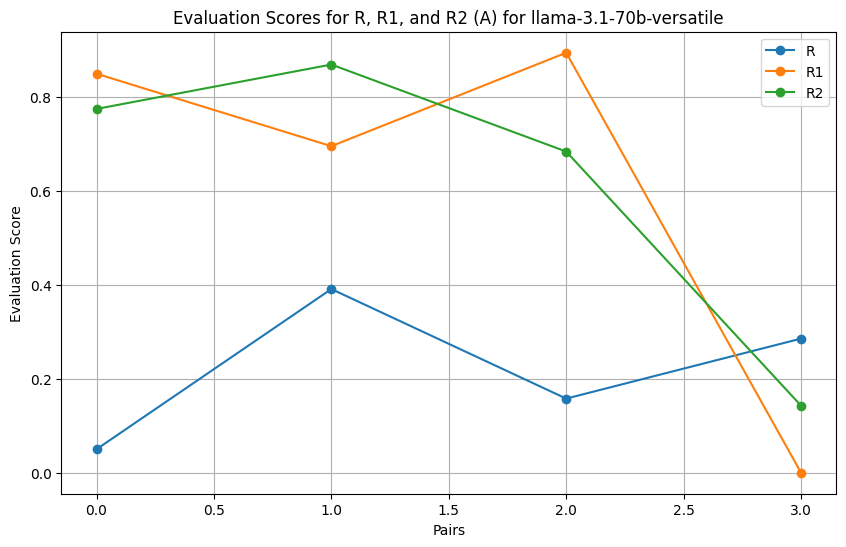

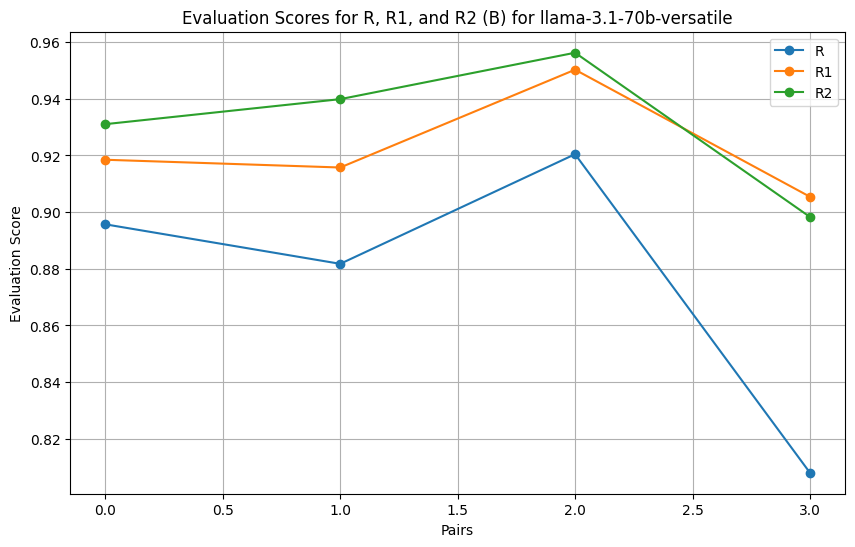

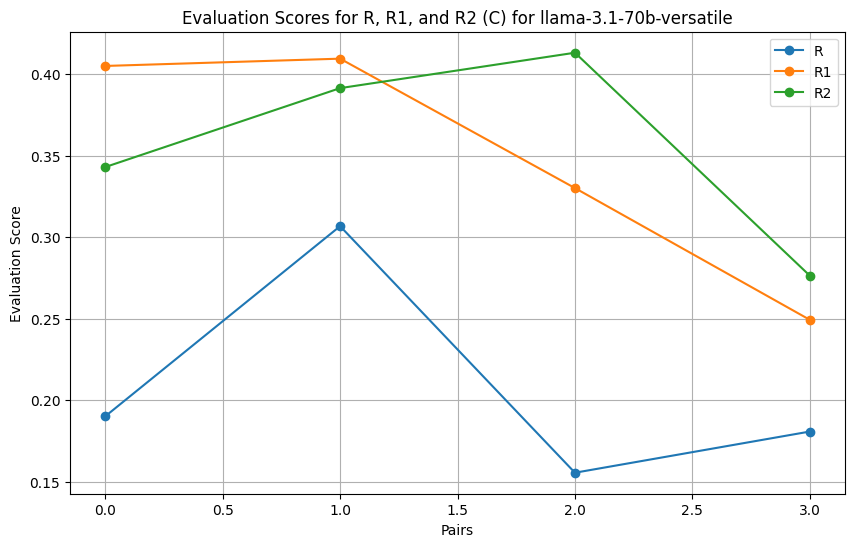

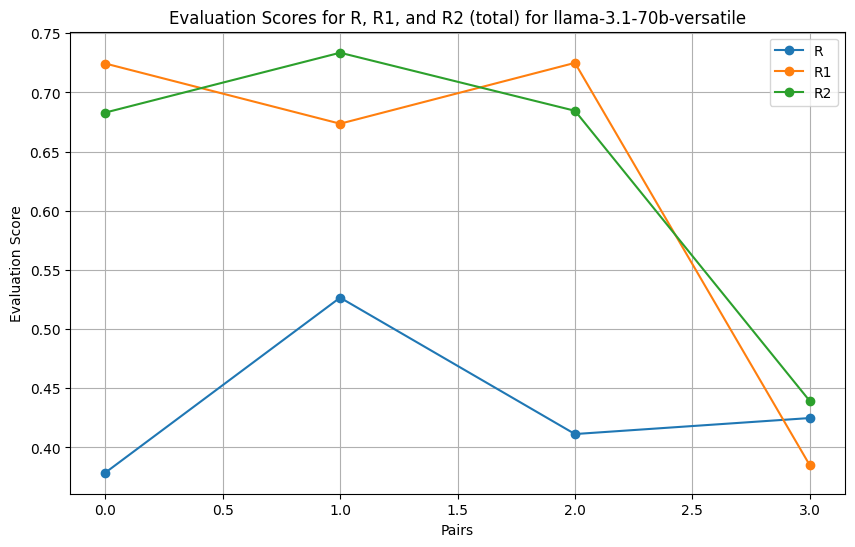

Results for llama-3.2-90b-text-preview:
Average Evaluation Score for R: 0.4371544996145654
Average Evaluation Score for R1: 0.5774336770940104
Average Evaluation Score for R2: 0.5776433689482731


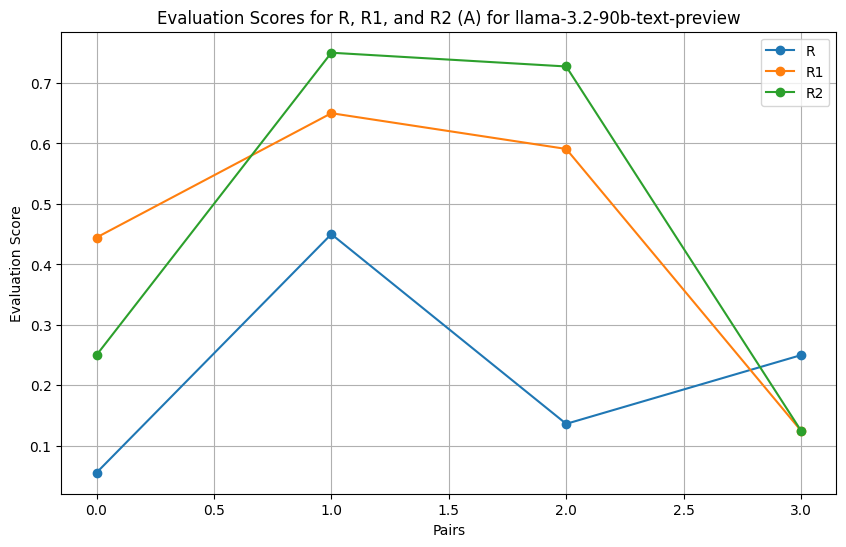

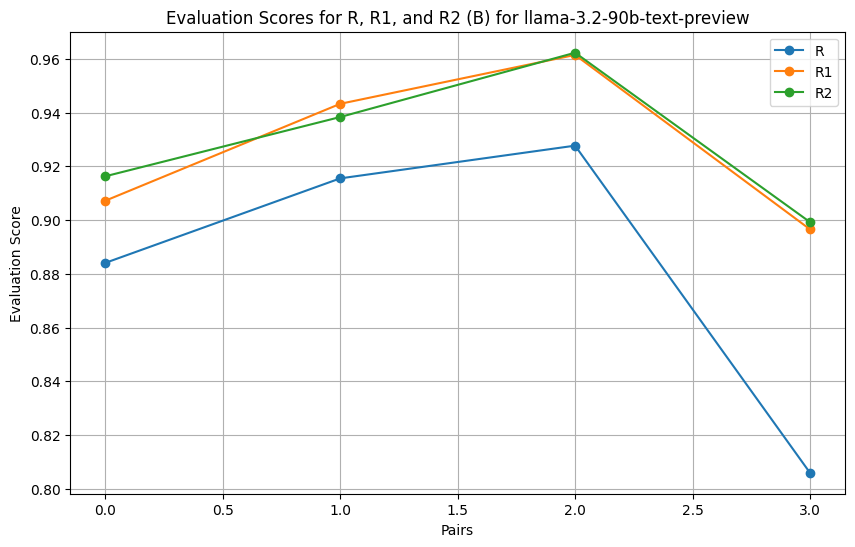

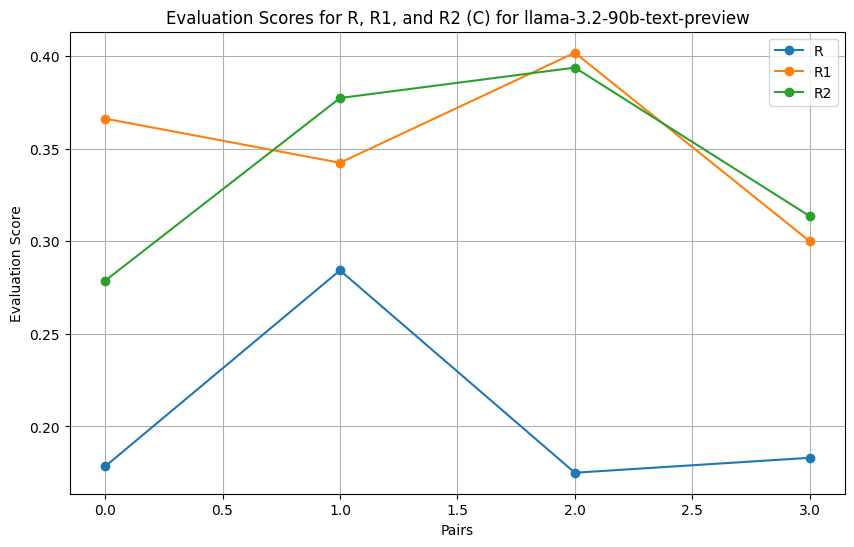

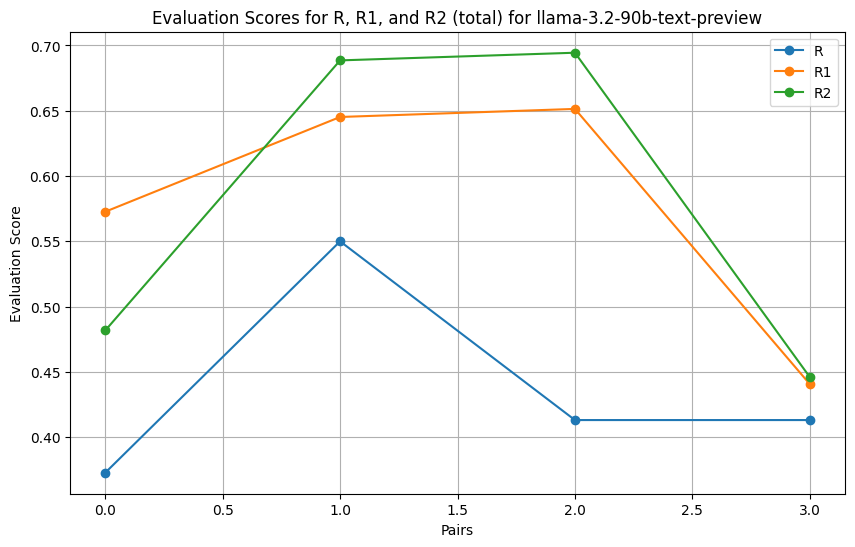

In [20]:
# Function to calculate average scores for a list
def calculate_average(scores):
    return sum(scores) / len(scores)

# Function to get averages for a given category
def get_avg_scores(r, r1, r2):
    avg_r = calculate_average(r)
    avg_r1 = calculate_average(r1)
    avg_r2 = calculate_average(r2)
    return [avg_r, avg_r1, avg_r2]

# Plotting function
def plot_evaluation_scores(r, r1, r2, Z, llm):
    plt.figure(figsize=(10, 6))
    plt.plot(r, label='R', marker='o')
    plt.plot(r1, label='R1', marker='o')
    plt.plot(r2, label='R2', marker='o')
    plt.xlabel('Pairs')
    plt.ylabel('Evaluation Score')
    plt.title(f'Evaluation Scores for R, R1, and R2 ({Z}) for {llm}')
    plt.legend()
    plt.grid(True)
    plt.show()

BEST_MODEL_AND_R = []

for llm in llm_models:
    print(f"Results for {llm}:")
    m = results[llm]
    A_scores = m[0][0]
    B_scores = m[0][1]
    C_scores = m[0][2]
    total_scores = m[0][3]

    r_A = A_scores[0]
    r1_A = A_scores[1]
    r2_A = A_scores[2]

    r_B = B_scores[0]
    r1_B = B_scores[1]
    r2_B = B_scores[2]

    r_C = C_scores[0]
    r1_C = C_scores[1]
    r2_C = C_scores[2]

    r = total_scores[0]
    r1 = total_scores[1]
    r2 = total_scores[2]

    # Calculate average scores for each category
    avg_scores_A = get_avg_scores(r_A, r1_A, r2_A)
    avg_scores_B = get_avg_scores(r_B, r1_B, r2_B)
    avg_scores_C = get_avg_scores(r_C, r1_C, r2_C)
    avg_scores_total = get_avg_scores(r, r1, r2)

    # Print results
    # print(f"Average Evaluation Score A for R: {avg_scores_A[0]}")
    # print(f"Average Evaluation Score A for R1: {avg_scores_A[1]}")
    # print(f"Average Evaluation Score A for R2: {avg_scores_A[2]}")

    # print(f"Average Evaluation Score B for R: {avg_scores_B[0]}")
    # print(f"Average Evaluation Score B for R1: {avg_scores_B[1]}")
    # print(f"Average Evaluation Score B for R2: {avg_scores_B[2]}")

    # print(f"Average Evaluation Score C for R: {avg_scores_C[0]}")
    # print(f"Average Evaluation Score C for R1: {avg_scores_C[1]}")
    # print(f"Average Evaluation Score C for R2: {avg_scores_C[2]}")

    print(f"Average Evaluation Score for R: {avg_scores_total[0]}")
    print(f"Average Evaluation Score for R1: {avg_scores_total[1]}")
    print(f"Average Evaluation Score for R2: {avg_scores_total[2]}")

    best_r_score = 0
    best_r = None
    for i in range(len(avg_scores_total)):
        if avg_scores_total[i] > best_r_score:
            best_r_score = avg_scores_total[i]
            if i == 0:
                best_r = "R"
            elif i == 1:
                best_r = "R1"
            elif i == 2:
                best_r = "R2"

    BEST_MODEL_AND_R.append([llm, best_r, best_r_score])

    # Plot the evaluation scores
    plot_evaluation_scores(r_A, r1_A, r2_A, "A", llm)
    plot_evaluation_scores(r_B, r1_B, r2_B, "B", llm)
    plot_evaluation_scores(r_C, r1_C, r2_C, "C", llm)
    plot_evaluation_scores(r, r1, r2, "total", llm)

# Selecting Best Version

In [21]:
best_score = 0
best_model_and_r = None
for item in BEST_MODEL_AND_R:
    print(item)
    if item[2] > best_score:
        best_score = item[2]
        best_model_and_r = [item[0], item[1]]

print(f"Best Model and R: {best_model_and_r}")

# Write this in a file
with open("/content/drive/My Drive/LLM_RESUME_DATA/LLM Project Final/Mid Review 2/best_model_and_r.txt", "w") as file:
    # first line is model name
    file.write(best_model_and_r[0])
    file.write("\n")
    # second line is R
    file.write(best_model_and_r[1])
    file.write("\n")

['llama-3.1-70b-versatile', 'R2', 0.6350886409211411]
['llama-3.2-90b-text-preview', 'R2', 0.5776433689482731]
Best Model and R: ['llama-3.1-70b-versatile', 'R2']
